# Basic concepts of Mol2vec

This notebook covers basic concepts of [Mol2vec](https://chemrxiv.org/articles/Mol2vec_Unsupervised_Machine_Learning_Approach_with_Chemical_Intuition/5513581) from generation of "molecular sentences" to plotting embeddings obtained with Mol2vec.
* [Encoding substructures of a molecule as words](#Encoding-substructures-of-a-molecule-as-words)
* [Exploring Mol2vec embeddings](#Exploring-Mol2vec-embeddings)
* [Plotting of an amino acid (ALA) substructure vectors](#Plotting-of-an-amino-acid-%28ALA%29-substructure-vectors)
* [Plotting all amino acids in grid plot](#Plotting-all-amino-acids-in-grid-plot)


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

In [3]:
import urllib3
import json
import traceback
import xmltodict
from datetime import datetime

### Settings

In [4]:
PROT = False
SAVE = True

### Get list of Luo dataset IDs

In [5]:
if(PROT):
    luo_url = 'https://raw.githubusercontent.com/luoyunan/DTINet/master/data/protein.txt'
else:
    luo_url = 'https://raw.githubusercontent.com/luoyunan/DTINet/master/data/drug.txt'
http = urllib3.PoolManager()
response = http.request('GET', luo_url)

In [6]:
luo_ids = response.data.decode().split("\n")
luo_ids = list(filter(None, luo_ids))
len(luo_ids)

708

### Get SMILES from pubchem
https://www.biostars.org/p/271718/

In [7]:
def getxml(drug_url):
    # url = "https://yoursite/your.xml"

    http = urllib3.PoolManager()

    response = http.request('GET', drug_url)
    try:
        data = xmltodict.parse(response.data)
    except:
        print("Failed to parse xml from response (%s)" % traceback.format_exc())
    if 'Fault' in data.keys():
        print("Code: {code}, \nMessage: {message}, \nDetails: {details} : ({trace})"
              .format(trace = traceback.format_exc(),
                      code = data['Fault']['Code'],
                      message = data['Fault']['Message'],
                      details = data['Fault']['Details'],
                     )
             )
    return data

In [8]:
# TODOs
# make the get_smiles code into a function: get_smiles(id) -> smiles
# save smiles into a file of appropriate format 

# PSEUDOCODE
# for each drug id in Luo datasets do:
drug_id = 'DB01030'
drug_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/drugbank/{id}/XML".format(id = drug_id)
print(drug_url)
page_xml_drug = getxml(drug_url)
print(page_xml_drug.keys())

https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/drugbank/DB01030/XML
dict_keys(['PC-Substances'])


In [9]:
drug_pubchem_id = page_xml_drug['PC-Substances']\
    ['PC-Substance']\
    ['PC-Substance_compound']\
    ['PC-Compounds']\
    ['PC-Compound'][-1]\
    ['PC-Compound_id']\
    ['PC-CompoundType']\
    ['PC-CompoundType_id']\
    ['PC-CompoundType_id_cid']
drug_pubchem_id

'60700'

In [10]:
smiles_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{pubchem_id}/XML".format(pubchem_id = drug_pubchem_id)
smiles_url

'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/60700/XML'

In [11]:
page_xml_smiles = getxml(smiles_url)

In [12]:
xml_smiles_infodata = page_xml_smiles['PC-Compounds']['PC-Compound']['PC-Compound_props']['PC-InfoData']

for info_data in xml_smiles_infodata:
    # print(info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_label'])
    if info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_label'] == 'SMILES':
        if info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_name'] == 'Canonical':
            print(info_data['PC-InfoData_value']['PC-InfoData_value_sval'])

CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=C(C=CC(=C5CN(C)C)O)N=C4C3=C2)O


### Get SMILES for all Luo drugs

In [13]:
def get_smiles_by_luo_id(drug_luo_id):
#     get pubchem drug xml
    drug_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/drugbank/{id}/XML".format(id = drug_luo_id)
    page_xml_drug = getxml(drug_url)
    
#     get pubchem drug ID
    drug_pubchem_id = page_xml_drug['PC-Substances']\
        ['PC-Substance']\
        ['PC-Substance_compound']\
        ['PC-Compounds']\
        ['PC-Compound'][-1]\
        ['PC-Compound_id']\
        ['PC-CompoundType']\
        ['PC-CompoundType_id']\
        ['PC-CompoundType_id_cid']
    
#     get pubchem drug xml containing SMILES
    smiles_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{pubchem_id}/XML".format(pubchem_id = drug_pubchem_id)
    page_xml_smiles = getxml(smiles_url)    
    
#     get SMILES from xml
    xml_smiles_infodata = page_xml_smiles['PC-Compounds']['PC-Compound']['PC-Compound_props']['PC-InfoData']

    for info_data in xml_smiles_infodata:
        # print(info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_label'])
        if info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_label'] == 'SMILES':
            if info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_name'] == 'Canonical':
                smiles = info_data['PC-InfoData_value']['PC-InfoData_value_sval']
    
    return smiles

if(PROT):
    pass
else:
    get_smiles_by_luo_id(luo_ids[0])
# todo build dictionary {ID:SMILES}

In [14]:
def get_smiles_by_drug_page_xml(page_xml_drug):
# NOT necessary now - is done in the code before this func
    #     get pubchem drug xml
    # drug_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/drugbank/{id}/XML".format(id = drug_luo_id)
    # page_xml_drug = getxml(drug_url)
    
#     get pubchem drug ID
    drug_pubchem_id = page_xml_drug['PC-Substances']\
        ['PC-Substance']\
        ['PC-Substance_compound']\
        ['PC-Compounds']\
        ['PC-Compound'][-1]\
        ['PC-Compound_id']\
        ['PC-CompoundType']\
        ['PC-CompoundType_id']\
        ['PC-CompoundType_id_cid']
    
#     get pubchem drug xml containing SMILES
    smiles_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{pubchem_id}/XML".format(pubchem_id = drug_pubchem_id)
    page_xml_smiles = getxml(smiles_url)    
    
#     get SMILES from xml
    xml_smiles_infodata = page_xml_smiles['PC-Compounds']['PC-Compound']['PC-Compound_props']['PC-InfoData']

    for info_data in xml_smiles_infodata:
        # print(info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_label'])
        if info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_label'] == 'SMILES':
            if info_data['PC-InfoData_urn']['PC-Urn']['PC-Urn_name'] == 'Canonical':
                smiles = info_data['PC-InfoData_value']['PC-InfoData_value_sval']
    
    return smiles

In [15]:
print(datetime.now())

def get_all_smiles_by_ids(luo_ids_to_get):
    # set up
    id_to_smiles = {}
    errors = {}
    errors['bad_request'] = [] # DB01258
    errors['no_substances'] = [] # nothing so far
    errors['no_substance_compound'] = [] # DB00375

    for drug_id in luo_ids_to_get:
        # print(drug_id)
    #     get pubchem drug xml
        drug_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/drugbank/{id}/XML".format(id = drug_id)
        page_xml_drug = getxml(drug_url)
        
        if 'Fault' in page_xml_drug.keys():
            errors['bad_request'].append({str(drug_id): page_xml_drug})

        if 'PC-Substances' not in page_xml_drug.keys():
            errors['no_substances'].append(drug_id)
            
        elif 'PC-Substance_compound' not in page_xml_drug['PC-Substances']['PC-Substance'].keys():
            errors['no_substance_compound'].append(drug_id)
            
        else:
            drug_smiles = get_smiles_by_drug_page_xml(page_xml_drug)
            id_to_smiles[str(drug_id)] = drug_smiles
            
    return id_to_smiles, errors

# TODO uncomment for SMILES collection
id_to_smiles, processing_errors = get_all_smiles_by_ids(luo_ids)
print(len(id_to_smiles))

print(datetime.now())

2022-11-20 11:30:27.508182
Code: PUGREST.BadRequest, 
Message: Invalid identifier, 
Details: Expected a valid identifier for the given source : (NoneType: None
)
705
2022-11-20 11:44:59.785878


### Not all SMILES are in the pubchem DB

In [16]:
len(luo_ids)

708

In [17]:
print(len(id_to_smiles))

705


In [18]:
processing_errors

{'bad_request': [{'DB01258': {'Fault': {'@xmlns': 'http://pubchem.ncbi.nlm.nih.gov/pug_rest',
     '@xmlns:xs': 'http://www.w3.org/2001/XMLSchema-instance',
     '@xs:schemaLocation': 'http://pubchem.ncbi.nlm.nih.gov/pug_rest https://pubchem.ncbi.nlm.nih.gov/pug_rest/pug_rest.xsd',
     'Code': 'PUGREST.BadRequest',
     'Message': 'Invalid identifier',
     'Details': 'Expected a valid identifier for the given source'}}}],
 'no_substances': ['DB01258'],
 'no_substance_compound': ['DB00375', 'DB00994']}

In [19]:
hard_coded_smiles = {
    'DB01258': 'COCCCOC1=C(OC)C=CC(C[C@@H](C[C@H](N)[C@@H](O)C[C@@H](C(C)C)C(=O)NCC(C)(C)C(N)=O)C(C)C)=C1',
    'DB00375': 'C1C(O1)CCl.C(CNCCNCCNCCN)N',
    'DB00994': 'O([C@H]3[C@H](O[C@@H]2O[C@H](CO)[C@@H](O[C@H]1O[C@@H](CN)[C@@H](O)[C@H](O)[C@H]1N)[C@H]2O)[C@@H](O)[C@H](N)C[C@@H]3N)[C@H]4O[C@@H]([C@@H](O)[C@H](O)[C@H]4N)CN',
}

In [20]:
for key in hard_coded_smiles.keys():
    id_to_smiles[key] = hard_coded_smiles[key]

In [21]:
len(id_to_smiles)

708

In [22]:
def get_all_protein_by_ids(luo_ids_to_get):
    luo_id_to_seq = {}
    errors = {}
    
    
    
    return luo_id_to_seq, errors
# id_to_seq, processing_errors = get_all_seqs_by_ids(luo_ids)

In [23]:
# save errors
if(SAVE):
   json.dump(processing_errors, open("errors.txt",'w'))

# load errors #TODO probably not correct (bad_request and no_substances), DB01258 should probably be bad_request 
processing_errors = json.load(open("errors.txt"))
print(processing_errors)

{'bad_request': [{'DB01258': {'Fault': {'@xmlns': 'http://pubchem.ncbi.nlm.nih.gov/pug_rest', '@xmlns:xs': 'http://www.w3.org/2001/XMLSchema-instance', '@xs:schemaLocation': 'http://pubchem.ncbi.nlm.nih.gov/pug_rest https://pubchem.ncbi.nlm.nih.gov/pug_rest/pug_rest.xsd', 'Code': 'PUGREST.BadRequest', 'Message': 'Invalid identifier', 'Details': 'Expected a valid identifier for the given source'}}}], 'no_substances': ['DB01258'], 'no_substance_compound': ['DB00375', 'DB00994']}


### Save id_to_smiles mapping to a file

In [24]:
if(SAVE):
   json.dump(id_to_smiles, open("id_to_smiles.txt",'w'))

### Load id_to_smiles mapping from a file

In [25]:
id_to_smiles = json.load(open("id_to_smiles.txt"))
print(len(id_to_smiles))

708


### Map SMILES with mol2vec
- TODO process id_to_smiles dict into a appropriate dataset object
- TODO map proteins in the similar way
- TODO chembl or zink to find "different canonical SMILES' formes" to fix the "missing in the vocab problem"

In [26]:
# id_to_smiles['DB00050']
if(PROT):
    smiles_in_order = ['Q9UI32']
else:
    smiles_in_order = list(id_to_smiles.values())
    

In [27]:
from gensim.models import word2vec

# model.wv.get_vector('2246728737')

# Switch to proteins
if(PROT):
    prot_sample = 'MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQGRETPHSHQPQHQDHDSSESGMLSRLGDLLFYTIAEGQERIPIHKFTTALKATGLQTSDPRLRDCMSEMHRVVQESSSGGLLDRDLFRKCVSSNIVLLTQAFRKKFVIPDFEEFTGHVDRIFEDVKELTGGKVAAYIPQLAKSNPDLWGVSLCTVDGQRHSVGHTKIPFCLQSCVKPLTYAISISTLGTDYVHKFVGKEPSGLRYNKLSLNEEGIPHNPMVNAGAIVVSSLIKMDCNKAEKFDFVLQYLNKMAGNEYMGFSNATFQSEKETGDRNYAIGYYLKEKKCFPKGVDMMAALDLYFQLCSVEVTCESGSVMAATLANGGICPITGESVLSAEAVRNTLSLMHSCGMYDFSGQFAFHVGLPAKSAVSGAILLVVPNVMGMMCLSPPLDKLGNSHRGTSFCQKLVSLFNFHNYDNLRHCARKLDPRREGAEIRNKTVVNLLFAAYSGDVSALRRFALSAMDMEQKDYDSRTALHVAAAEGHIEVVKFLIEACKVNPFAKDRWGNIPLDDAVQFNHLEVVKLLQDYQDSYTLSETQAEAAAEALSKENLESMV'
    # protein_mols = [Chem.MolFromSequence(prot_sample)]


id_to_vec = {}

model = word2vec.Word2Vec.load('mol2vec/examples/models/model_300dim.pkl')

# aa_smis = smiles_in_order
if(PROT):
    chem_mols = [Chem.MolFromSequence(prot_sample)]
else:
    chem_mols = [Chem.MolFromSmiles(x) for x in smiles_in_order]
print(len(chem_mols))

sentences = [mol2alt_sentence(x, 1) for x in chem_mols]
print(len(sentences))

# flat_list = [item for sublist in sentences for item in sublist]
# print(len(flat_list))
# aa_identifiers_unique = set(flat_list)
# print(len(aa_identifiers_unique))

# df_vec = pd.DataFrame()
# df_vec['identifier'] = list(aa_identifiers_unique)
# df_vec.index = df_vec['identifier']
# print(len(df_vec))

# for luo_id in id_to_smiles.keys():
#     # vec = mapping_product
#     id_to_vec[str(luo_id)] = vec
    
#     pass
    # map SMILE S to VEC
    # save VEC in a new dict of type = {LUO_ID: VEC}    

708
708


In [28]:

print(np.shape(sentences))
maximum = 0
max_i = -1
for index, mol in enumerate(sentences):
    # print(len(sentence))
    if maximum < len(mol):
        maximum = len(mol)
        max_i = index
print(max_i)
print(maximum)

sentence = []
for word in sentences[max_i]:
    sentence.append(model.wv.get_vector(word))
    
np.shape(sentence)[0] * np.shape(sentence)[1]
    

(708,)
696
242


/home/jovyan/my-conda-envs/mol2vec/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


72600

In [29]:
count = 0 
for i in range(len(sentences)):
    count = count + len(sentences[i])
count

35649

### Sentence2Vec
error "The vocab attribute was removed from KeyedVector in Gensim 4.0.0."
- summing on my own

In [30]:
print(np.shape(sentences))

sentence_embedding = {}
missing_words = {}
missing_words_portion = {}

for index, sentence_mol in enumerate(sentences):
    word_embeddings = []
    missing_portion = []
    # print(index)
    for word in sentence_mol:
        try:
            word_embeddings.append(model.wv.get_vector(word))
        except:
            if not str(index) in missing_words.keys():
                missing_words[str(index)] = []
            missing_words[str(index)].append(word)
            missing_portion.append(1)
    
    if(missing_portion):
        missing_words_portion[str(index)] = sum(missing_portion) / len(sentence_mol)      
    sentence_embedding[str(index)] = [sum(x) for x in zip(*word_embeddings)]

missing_words
missing_words_portion

(708,)


{'121': 0.19047619047619047,
 '208': 0.6666666666666666,
 '455': 1.0,
 '577': 0.3,
 '649': 1.0,
 '653': 1.0,
 '654': 1.0}

In [72]:
for i in sentence_embedding.values():
    if np.shape(i)[0] != 300:
        print(np.shape(i))

(0,)
(0,)
(0,)
(0,)


### Is the whole drug missing from the model's vocabulary or only a part of it (a word)?

In [32]:
max(sentence_embedding['0'])
missing_in_sentences = None
missing_in_missingwords = None

for key in missing_words.keys():
    # sentences[int(key)] diff missing_words[int(key)] and vice versa
    missing_in_sentences = set(sentences[int(key)]) - set(missing_words[key])
    missing_in_missingwords = set(missing_words[key]) - set(sentences[int(key)])

=> Both directions of difference are empty => the whole drugs are missing from the model's vocabulary not just their parts

In [33]:
if(missing_in_sentences):
    print(missing_in_sentences)

In [34]:
missing_in_missingwords

set()

### Put it all together into a dict of type: {LuoID -> Vec} and a list of missing vectorizations: [LuoID]
- sentences missing from vocabulary are in the form of an empty list in the sentence_embedding dict

In [35]:
print(np.shape(list(id_to_smiles.keys())))
print(np.shape(sentences))
print(np.shape(list(sentence_embedding.keys())))

(708,)
(708,)
(708,)


In [36]:
# set luo_id_to_vec

luo_id_to_vec = {}
luo_ids = list(id_to_smiles.keys())
for i, embedding in enumerate(sentence_embedding.values()):
    luo_id_to_vec[str(luo_ids[i])] = embedding
print(np.shape(list(luo_id_to_vec.keys())))

# save to file
if(SAVE):
    json.dump(luo_id_to_vec, open("luo_id_to_vec.txt",'w'))

(708,)


In [37]:
for x,y in zip(luo_ids, list(luo_id_to_vec.keys())):
    if x != y:
        print('not in order')

In [38]:
# set luo_id_to_missing_portion

luo_id_to_missing_portion = {}

for index, key in enumerate(luo_id_to_vec.keys()):
    if str(index) in list(missing_words_portion.keys()):
        luo_id_to_missing_portion[key] = missing_words_portion[str(index)]
        
print(luo_id_to_missing_portion)

# save to file
if(SAVE):
    json.dump(luo_id_to_missing_portion, open("luo_id_to_missing_portion.txt",'w'))

{'DB00364': 0.19047619047619047, 'DB00515': 0.6666666666666666, 'DB00958': 1.0, 'DB01169': 0.3, 'DB01356': 1.0, 'DB01378': 1.0, 'DB01390': 1.0}


In [39]:
# filter drugs(sentences) with subparts(words) missing in vocabulary 
import copy
luo_id_to_vec_cleaned = copy.deepcopy(luo_id_to_vec)

for luo_id in luo_id_to_missing_portion.keys():
    del luo_id_to_vec_cleaned[luo_id]
    print(luo_id, '- record deleted')

if(SAVE):
    json.dump(luo_id_to_vec_cleaned, open("luo_id_to_vec_cleaned.txt",'w'))

DB00364 - record deleted
DB00515 - record deleted
DB00958 - record deleted
DB01169 - record deleted
DB01356 - record deleted
DB01378 - record deleted
DB01390 - record deleted


In [40]:
corrected_smiles = {}
corrected_smiles['DB00364'] = [
    'C(C1C(C(C(C(O1)OC2(C(C(C(O2)OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])COS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al].O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O',
     # Canonical SMILES
    'C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O[C@]2([C@H]([C@@H]([C@H](O2)OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])COS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al].O.O.O.O.O.O.O.O.O.O.O.O.O.O.O.O',
    'O.O[Al](O)O.O[Al](O)OS(=O)(=O)OC[C@H]1O[C@@](COS(=O)(=O)O[Al](O)O)(O[C@H]2O[C@H](COS(=O)(=O)O[Al](O)O)[C@@H](OS(=O)(=O)O[Al](O)O)[C@H](OS(=O)(=O)O[Al](O)O)[C@H]2OS(=O)(=O)O[Al](O)O)[C@@H](OS(=O)(=O)O[Al](O)O)[C@@H]1OS(=O)(=O)O[Al](O)O',
    'O[Al](O)OS(=O)(=O)OC[C@H]1O[C@@H](O[C@]2(COS(=O)(=O)O[Al](O)O)O[C@H](OS(=O)(=O)O[Al](O)O)[C@@H](OS(=O)(=O)O[Al](O)O)[C@@H]2OS(=O)(=O)O[Al](O)O)[C@H](OS(=O)(=O)O[Al](O)O)[C@@H](OS(=O)(=O)O[Al](O)O)[C@@H]1OS(=O)(=O)O[Al](O)O',
]
corrected_smiles['DB00515'] = [
    '[NH2-].[NH2-].Cl[Pt+2]Cl', # Canonical SMILES
    '[H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H]',
    '[NH3+]-[Pt-2](Cl)(Cl)[NH3+]',
    'N[Pt](N)(Cl)Cl',
    'N.N.Cl[Pt+2]Cl',
]
corrected_smiles['DB00958'] = [
    'C1CC(C1)(C(=O)O)C(=O)O.N.N.[Pt]', # Canonical SMILES
    '[H][N]([H])([H])[Pt]1(OC(=O)C2(CCC2)C(=O)O1)[N]([H])([H])[H]',
    'C1CC2(C1)C(=O)O[Pt-2]([NH3+])([NH3+])OC2=O',
]
corrected_smiles['DB01169'] = [
    'O=[As]O[As]=O', # Canonical SMILES
    'O1[As]3O[As]2O[As](O3)O[As]1O2',
    'O1[As]2O[As]1O2',
]
corrected_smiles['DB01356'] = [
    '[Li+]', # Canonical SMILES
]
corrected_smiles['DB01378'] = [
    '[Mg+2]', # Canonical SMILES
    '[Mg++]',
]
corrected_smiles['DB01390'] = [
    'C(=O)(O)[O-].[Na+]', # Canonical SMILES
    '[Na+].OC([O-])=O',
]

In [41]:
for key in luo_id_to_missing_portion.keys():
    print('\n', str(luo_id_to_missing_portion[key]) + ' portion of ')
    print(id_to_smiles[key])
    print(key)


 0.19047619047619047 portion of 
C(C1C(C(C(C(O1)OC2(C(C(C(O2)COS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])COS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al])OS(=O)(=O)O[Al]
DB00364

 0.6666666666666666 portion of 
Cl[Pt+2]Cl
DB00515

 1.0 portion of 
[Pt]
DB00958

 0.3 portion of 
O=[As]O[As]=O
DB01169

 1.0 portion of 
[Li]
DB01356

 1.0 portion of 
[Mg]
DB01378

 1.0 portion of 
[Na]
DB01390


OR - Get SMILES from DrugBank DB

In [42]:
# import xml.etree.ElementTree as ET
# tree = ET.parse('full database.xml')
# root = tree.getroot()

In [43]:
# root.__dir__()

In [44]:
# # for child in root:
#     # print(child.tag, child.attrib)
# child = root
# while child:
#     # [print (child[str(x)]) for x in child.keys()]
#     print(child.items())
#     child = child[0]

# print(child.items())



### Get Mol for prot sequence
- Chem.MolFromSequence

In [45]:
prot_sample = 'MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQGRETPHSHQPQHQDHDSSESGMLSRLGDLLFYTIAEGQERIPIHKFTTALKATGLQTSDPRLRDCMSEMHRVVQESSSGGLLDRDLFRKCVSSNIVLLTQAFRKKFVIPDFEEFTGHVDRIFEDVKELTGGKVAAYIPQLAKSNPDLWGVSLCTVDGQRHSVGHTKIPFCLQSCVKPLTYAISISTLGTDYVHKFVGKEPSGLRYNKLSLNEEGIPHNPMVNAGAIVVSSLIKMDCNKAEKFDFVLQYLNKMAGNEYMGFSNATFQSEKETGDRNYAIGYYLKEKKCFPKGVDMMAALDLYFQLCSVEVTCESGSVMAATLANGGICPITGESVLSAEAVRNTLSLMHSCGMYDFSGQFAFHVGLPAKSAVSGAILLVVPNVMGMMCLSPPLDKLGNSHRGTSFCQKLVSLFNFHNYDNLRHCARKLDPRREGAEIRNKTVVNLLFAAYSGDVSALRRFALSAMDMEQKDYDSRTALHVAAAEGHIEVVKFLIEACKVNPFAKDRWGNIPLDDAVQFNHLEVVKLLQDYQDSYTLSETQAEAAAEALSKENLESMV'
prot_sample = Chem.MolFromSequence(prot_sample)


# Mol2Vec example code

Canonical SMILES of amino acids

In [46]:
aa_smis = ['CC(N)C(=O)O', 'N=C(N)NCCCC(N)C(=O)O', 'NC(=O)CC(N)C(=O)O', 'NC(CC(=O)O)C(=O)O',
          'NC(CS)C(=O)O', 'NC(CCC(=O)O)C(=O)O', 'NC(=O)CCC(N)C(=O)O', 'NCC(=O)O',
          'NC(Cc1cnc[nH]1)C(=O)O', 'CCC(C)C(N)C(=O)O', 'CC(C)CC(N)C(=O)O', 'NCCCCC(N)C(=O)O',
          'CSCCC(N)C(=O)O', 'NC(Cc1ccccc1)C(=O)O', 'O=C(O)C1CCCN1', 'NC(CO)C(=O)O',
          'CC(O)C(N)C(=O)O', 'NC(Cc1c[nH]c2ccccc12)C(=O)O', 'NC(Cc1ccc(O)cc1)C(=O)O',
          'CC(C)C(N)C(=O)O']
aa_codes = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 
            'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

Generating molecules

In [47]:
aas = [Chem.MolFromSmiles(x) for x in aa_smis]

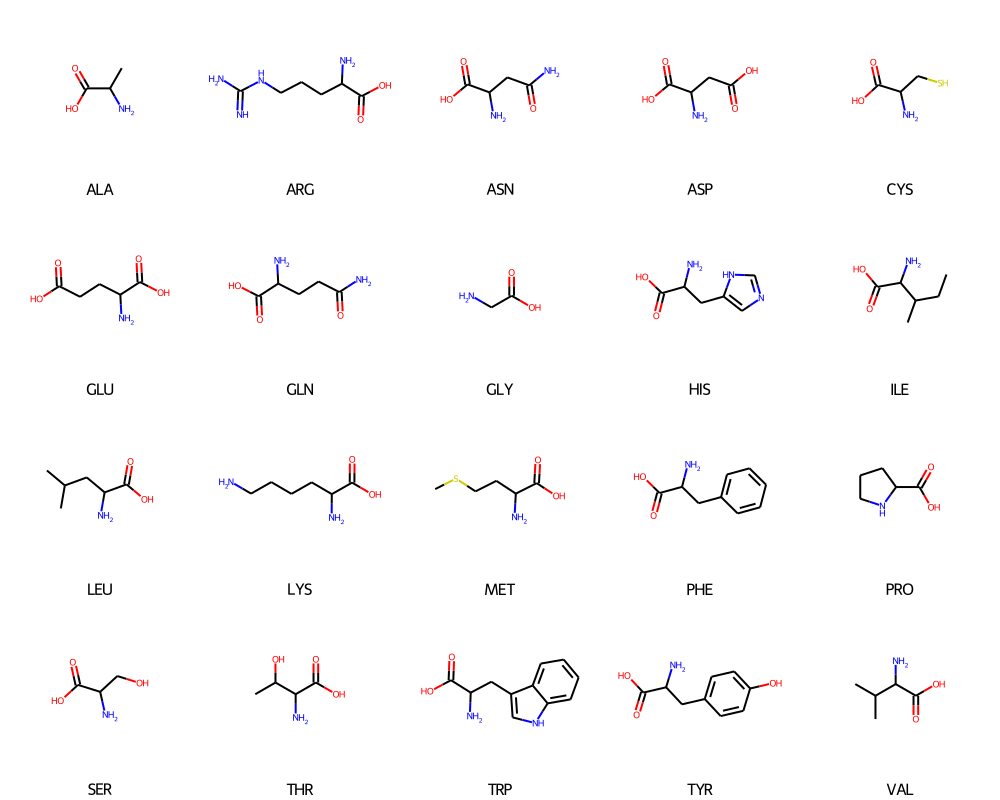

In [48]:
Draw.MolsToGridImage(aas, molsPerRow=5, useSVG=False, legends=aa_codes)

### Encoding substructures of a molecule as words

In [49]:
aa_smis[0]

'CC(N)C(=O)O'

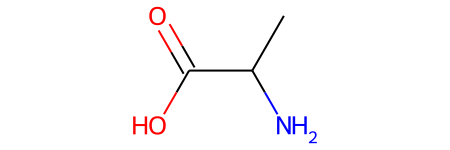

In [50]:
aas[0]

Mol2vec is based on [Word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) algorithm and we first have to encode molecules as sentences, meaning that each substructure (represented by Morgan identifier) represents a word.

In [51]:
sentence = mol2alt_sentence(aas[0], 1)
sentence

['2246728737',
 '3537119515',
 '2245273601',
 '2655406212',
 '847957139',
 '2599973650',
 '2246699815',
 '3855312692',
 '864942730',
 '1510328189',
 '864662311',
 '1533864325']

Depict a specific Morgan identifier - *depict_identifier(mol, identifier, radius)*

[11:45:03] The new font size 0.8 is below the current minimum (6).


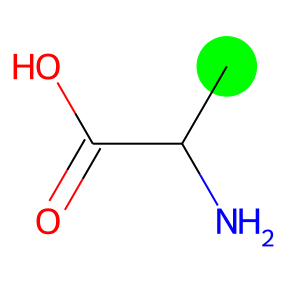

In [52]:
depict_identifier(aas[0], 2246728737, 1)

To depict all identifiers one can use IdentifierTable object -   
*IdentifierTable(identifiers_to_depict, mols_containing_selected_identifiers, sentences_for_mols, number_of_columns, radius)*

In [53]:
it = IdentifierTable(sentence, [aas[0]]*len(sentence), [sentence]*len(sentence), 5, 1)

[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).
[11:45:03] The new font size 0.8 is below the current minimum (6).


In [54]:
it

Sentences can be used to generate a corpus that can be used to train Mol2vec model. To generate high quality embeddings of substructures we recommend using a big database of molecules (millions) and use the command line scripts to prepare the corpus and train Mol2vec model.  
Type `mol2vec -h` into the command line to learn more.


### Exploring Mol2vec embeddings

Mol2vec uses [gensim implementation of Word2vec](https://radimrehurek.com/gensim/models/word2vec.html)

In [55]:
from gensim.models import word2vec

Load a pre-trained Mol2vec model which was trained on 20 million compounds downloaded from [ZINC](http://zinc.docking.org/) using:
- radius 1
- `UNK` to replace all identifiers that appear less than 4 times
- skip-gram and window size of 10
- resulting in 300 dimensional embeddings

In [56]:
model = word2vec.Word2Vec.load('mol2vec/examples/models/model_300dim.pkl')

Number of unique identifiers represented as vectors

In [57]:
# len(model.wv.vocab.keys()) # only works in version 3.x of Gensim
len(model.wv.index_to_key)

21003

Feature vector representing above depicted identifier **`2246728737`**

In [58]:
# model.wv.word_vec('2246728737') # soon depricated
print(len(model.wv.get_vector('2246728737')))
# model.wv.get_vector('2246728737')

300


Extraction of identifiers from molecules (amino acids)

In [59]:
aa_sentences = [mol2alt_sentence(x, 1) for x in aas]
flat_list = [item for sublist in aa_sentences for item in sublist]
aa_identifiers_unique = set(flat_list)

In [60]:
df_vec = pd.DataFrame()
df_vec['identifier'] = list(aa_identifiers_unique)
df_vec.index = df_vec['identifier']

Number of unique identifiers in amino acids

In [61]:
len(df_vec)

75

Projection of 300 dimensional vectors (representing identifiers) to 2 dimensions using a combination of PCA and t-SNE.  
We recommend fitting PCA/t-SNE using all identifiers to get better projections.

In [62]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [63]:
pca_model = PCA(n_components=30)
tsne_model = TSNE(n_components=2, perplexity=10, n_iter=1000, metric = 'cosine')
tsne_pca = tsne_model.fit_transform(pca_model.fit_transform([model.wv.word_vec(x) for x in aa_identifiers_unique]))

/tmp/ipykernel_86/254646706.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  tsne_pca = tsne_model.fit_transform(pca_model.fit_transform([model.wv.word_vec(x) for x in aa_identifiers_unique]))
/home/jovyan/my-conda-envs/mol2vec/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/my-conda-envs/mol2vec/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Save the two principal components to the data frame

In [64]:
df_vec['PCA-t-SNE-c1'] = tsne_pca.T[0]
df_vec['PCA-t-SNE-c2'] = tsne_pca.T[1]

In [65]:
df_vec.head(3)

,identifier,PCA-t-SNE-c1,PCA-t-SNE-c2
identifier,,,
3542456614,3542456614,-85.448418,-80.266991
1280488931,1280488931,-20.055471,210.930939
847957139,847957139,148.215973,-179.886719


In [66]:
projections = df_vec.to_dict()

Function that extracts projected values for plotting

In [67]:
def get_values(identifier, projections):
    return np.array((projections['PCA-t-SNE-c1'][str(identifier)],projections['PCA-t-SNE-c2'][str(identifier)]))

In [68]:
get_values(2246728737, projections)

array([-103.64774323,  -52.33383179])

### Plotting of an amino acid (ALA) substructure vectors

Substructure vectors are presented cyan and molecule vector violet.

In [69]:
aa_values = [get_values(x, projections) for x in aa_sentences[0]]

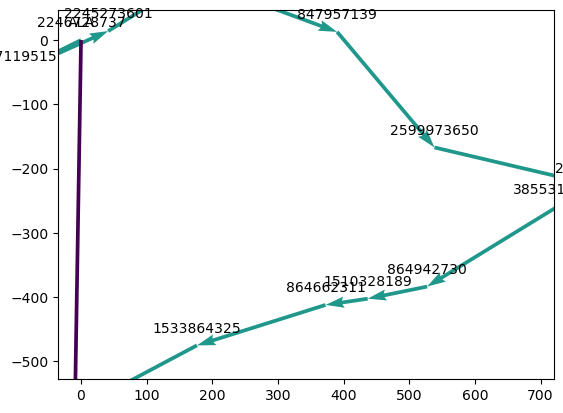

In [70]:
plot_2D_vectors(aa_values, vector_labels=aa_sentences[0] + ['ALA'], 
                );

### Plotting all amino acids in grid plot

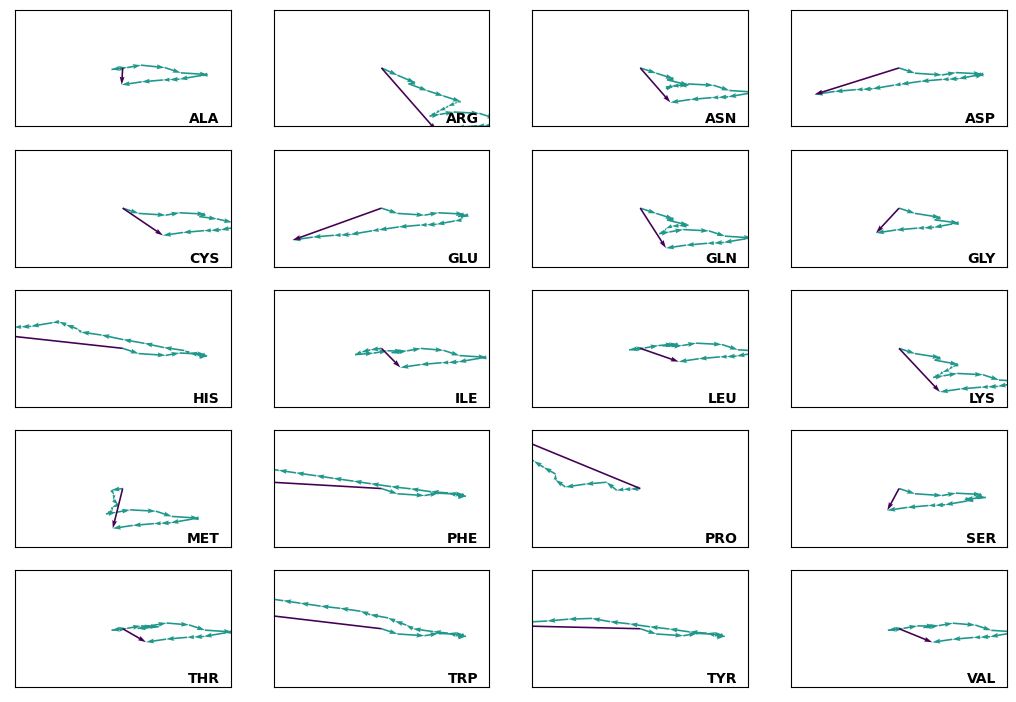

In [71]:
f, ((ALA, ARG, ASN, ASP), (CYS, GLU, GLN, GLY), (HIS, ILE, LEU, LYS), (MET, PHE, PRO, SER), (THR, TRP, TYR, VAL)) = plt.subplots(5,4, 
                                                    squeeze=True, sharex=True, sharey=True, 
                                                    figsize=(6.4*2,  4.4*2))

for aa,name,ax in zip(aas, aa_codes, (ALA, ARG, ASN, ASP, CYS, GLU, GLN, GLY, HIS, ILE, LEU, LYS, MET, PHE, PRO, SER, THR, TRP, TYR, VAL)):
    pca_subs = [get_values(x, projections) for x in mol2alt_sentence(aa, 1)]
    plot_2D_vectors(pca_subs, ax=ax, min_max_x=(-1000,1000), min_max_y=(-2000, 2000))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.95, 0.01, u"%s" % name,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, weight='bold',
            fontsize=10)